# Revenue Prediction Model - Training with Cross-Validation

## Objetivo
Entrenar y evaluar modelos de predicción de revenue usando **cross-validation** y **hyperparameter tuning** para obtener estimaciones más robustas de performance.

## Diferencias con model_development.ipynb:
- ✅ Cross-validation (5-fold) en train set
- ✅ Hyperparameter tuning con RandomizedSearchCV
- ✅ Evaluación más robusta con intervalos de confianza
- ✅ Comparación de modelos con estadísticas de varianza

## Contenido
1. Carga y preparación de datos
2. Feature Engineering
3. Cross-Validation de modelos base
4. Hyperparameter Tuning
5. Evaluación final y comparación
6. Exportación del mejor modelo

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import lightgbm as lgb
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Librerías cargadas correctamente')
print(f'XGBoost version: {xgb.__version__}')

✅ Librerías cargadas correctamente
XGBoost version: 3.1.2


## 1. Carga y Preparación de Datos

In [15]:
# Cargar dataset
df = pd.read_csv('../data/dataset.csv')

print(f'Dataset shape: {df.shape}')
print(f'\nValores nulos:')
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset shape: (20000, 11)

Valores nulos:
country_region    634
source            817
device_family       1
os_version          1
event_3           399
dtype: int64


## 2. Feature Engineering

Aplicamos el mismo pipeline de feature engineering que en el notebook original.

In [16]:
# Crear copia para procesamiento
df_processed = df.copy()

# ========================================
# MANEJO DE VALORES FALTANTES (NaN)
# ========================================
print('MANEJO DE VALORES FALTANTES')
print('=' * 70)
print(f'NaN antes: {df_processed.isnull().sum().sum()}')

# Variables numéricas
df_processed['event_3'].fillna(0, inplace=True)

# Variables categóricas
df_processed['country_region'].fillna('unknown', inplace=True)
df_processed['source'].fillna('unknown', inplace=True)
df_processed['device_family'].fillna('unknown', inplace=True)
df_processed['os_version'].fillna('unknown', inplace=True)

print(f'NaN después: {df_processed.isnull().sum().sum()}')
print('✅ Todos los NaN manejados\n')

# ========================================
# FEATURE ENGINEERING
# ========================================
print('FEATURE ENGINEERING')
print('=' * 70)

# Features derivadas
df_processed['total_events'] = df_processed['event_1'] + df_processed['event_2'] + df_processed['event_3']
df_processed['event_1_ratio'] = df_processed['event_1'] / (df_processed['total_events'] + 1)
df_processed['event_2_ratio'] = df_processed['event_2'] / (df_processed['total_events'] + 1)
df_processed['event_3_ratio'] = df_processed['event_3'] / (df_processed['total_events'] + 1)

# Normalizar platform
df_processed['platform'] = df_processed['platform'].str.lower()

# Frequency encoding
df_processed['country_freq'] = df_processed['country'].map(df_processed['country'].value_counts())
df_processed['device_family_freq'] = df_processed['device_family'].map(df_processed['device_family'].value_counts())
df_processed['country_region_freq'] = df_processed['country_region'].map(df_processed['country_region'].value_counts())

# Label encoding
le_source = LabelEncoder()
le_platform = LabelEncoder()
df_processed['source_encoded'] = le_source.fit_transform(df_processed['source'])
df_processed['platform_encoded'] = le_platform.fit_transform(df_processed['platform'])

# Target encoding para country
country_mean_revenue = df_processed.groupby('country')['revenue'].mean()
df_processed['country_mean_revenue'] = df_processed['country'].map(country_mean_revenue)

print('✅ Features creadas\n')

# Seleccionar features
feature_cols = [
    'event_1', 'event_2', 'event_3',
    'total_events', 'event_1_ratio', 'event_2_ratio', 'event_3_ratio',
    'country_freq', 'country_region_freq', 'device_family_freq',
    'source_encoded', 'platform_encoded',
    'country_mean_revenue'
]

X = df_processed[feature_cols]
y = df_processed['revenue']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nFeatures utilizadas ({len(feature_cols)}): {feature_cols}')

MANEJO DE VALORES FALTANTES
NaN antes: 1852
NaN después: 0
✅ Todos los NaN manejados

FEATURE ENGINEERING
✅ Features creadas

Features shape: (20000, 13)
Target shape: (20000,)

Features utilizadas (13): ['event_1', 'event_2', 'event_3', 'total_events', 'event_1_ratio', 'event_2_ratio', 'event_3_ratio', 'country_freq', 'country_region_freq', 'device_family_freq', 'source_encoded', 'platform_encoded', 'country_mean_revenue']


In [17]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print('TRAIN/TEST SPLIT')
print('=' * 70)
print(f'Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)')

TRAIN/TEST SPLIT
Train set: 16,000 samples (80.0%)
Test set:  4,000 samples (20.0%)


## 3. Cross-Validation de Modelos Base

Evaluamos cada modelo usando **5-fold cross-validation** en el train set para obtener una estimación más robusta de su performance.

In [18]:
# Definir modelos base (sin tunning)
base_models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, verbose=-1)
}

# Scoring metrics
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
    'R2': 'r2'
}

print('CROSS-VALIDATION DE MODELOS BASE (5-Fold)')
print('=' * 70)
print('\nEntrenando modelos con cross-validation...')
print('Modelos a evaluar: Ridge, Lasso, Random Forest, Gradient Boosting, XGBoost, LightGBM\n')

cv_results = {}

for name, model in base_models.items():
    print(f'\n{name}:')
    print('-' * 70)
    
    # Cross-validation
    cv_scores = cross_validate(
        model, 
        X_train, 
        y_train, 
        cv=5, 
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )
    
    # Calcular métricas promedio y std
    cv_results[name] = {
        'train_mae_mean': -cv_scores['train_MAE'].mean(),
        'train_mae_std': cv_scores['train_MAE'].std(),
        'val_mae_mean': -cv_scores['test_MAE'].mean(),
        'val_mae_std': cv_scores['test_MAE'].std(),
        'train_rmse_mean': -cv_scores['train_RMSE'].mean(),
        'val_rmse_mean': -cv_scores['test_RMSE'].mean(),
        'train_r2_mean': cv_scores['train_R2'].mean(),
        'val_r2_mean': cv_scores['test_R2'].mean(),
        'val_r2_std': cv_scores['test_R2'].std()
    }
    
    print(f"  Train MAE: {cv_results[name]['train_mae_mean']:.6f} (+/- {cv_results[name]['train_mae_std']:.6f})")
    print(f"  Val MAE:   {cv_results[name]['val_mae_mean']:.6f} (+/- {cv_results[name]['val_mae_std']:.6f})")
    print(f"  Train R²:  {cv_results[name]['train_r2_mean']:.6f}")
    print(f"  Val R²:    {cv_results[name]['val_r2_mean']:.6f} (+/- {cv_results[name]['val_r2_std']:.6f})")

print('\n' + '=' * 70)
print('✅ Cross-validation completada')

CROSS-VALIDATION DE MODELOS BASE (5-Fold)

Entrenando modelos con cross-validation...
Modelos a evaluar: Ridge, Lasso, Random Forest, Gradient Boosting, XGBoost, LightGBM


Ridge:
----------------------------------------------------------------------
  Train MAE: 64.566630 (+/- 7.326177)
  Val MAE:   64.563026 (+/- 8.024806)
  Train R²:  0.181714
  Val R²:    0.128002 (+/- 0.136300)

Lasso:
----------------------------------------------------------------------


/Users/seba/workspace/regal_cinemas/venv_regal/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e+09, tolerance: 1.120e+06
  model = cd_fast.enet_coordinate_descent(
/Users/seba/workspace/regal_cinemas/venv_regal/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+09, tolerance: 9.203e+05
  model = cd_fast.enet_coordinate_descent(
/Users/seba/workspace/regal_cinemas/venv_regal/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

  Train MAE: 64.572983 (+/- 7.326436)
  Val MAE:   64.569151 (+/- 8.024201)
  Train R²:  0.181714
  Val R²:    0.128001 (+/- 0.136302)

Random Forest:
----------------------------------------------------------------------
  Train MAE: 3.246571 (+/- 0.435770)
  Val MAE:   9.467095 (+/- 5.536154)
  Train R²:  0.973459
  Val R²:    0.835939 (+/- 0.078247)

Gradient Boosting:
----------------------------------------------------------------------
  Train MAE: 0.078179 (+/- 0.014838)
  Val MAE:   11.436969 (+/- 8.224097)
  Train R²:  0.999997
  Val R²:    0.659808 (+/- 0.355571)

XGBoost:
----------------------------------------------------------------------
  Train MAE: 0.322530 (+/- 0.050429)
  Val MAE:   9.802713 (+/- 4.721497)
  Train R²:  0.999933
  Val R²:    0.812900 (+/- 0.106805)

LightGBM:
----------------------------------------------------------------------
  Train MAE: 16.408957 (+/- 2.495771)
  Val MAE:   22.434946 (+/- 4.600282)
  Train R²:  0.752793
  Val R²:    0.327253 (+/-


RESULTADOS DE CROSS-VALIDATION (ordenados por Val MAE)
                   val_mae_mean  val_mae_std  val_r2_mean  val_r2_std
Random Forest          9.467095     5.536154     0.835939    0.078247
XGBoost                9.802713     4.721497     0.812900    0.106805
Gradient Boosting     11.436969     8.224097     0.659808    0.355571
LightGBM              22.434946     4.600282     0.327253    0.511051
Ridge                 64.563026     8.024806     0.128002    0.136300
Lasso                 64.569151     8.024201     0.128001    0.136302


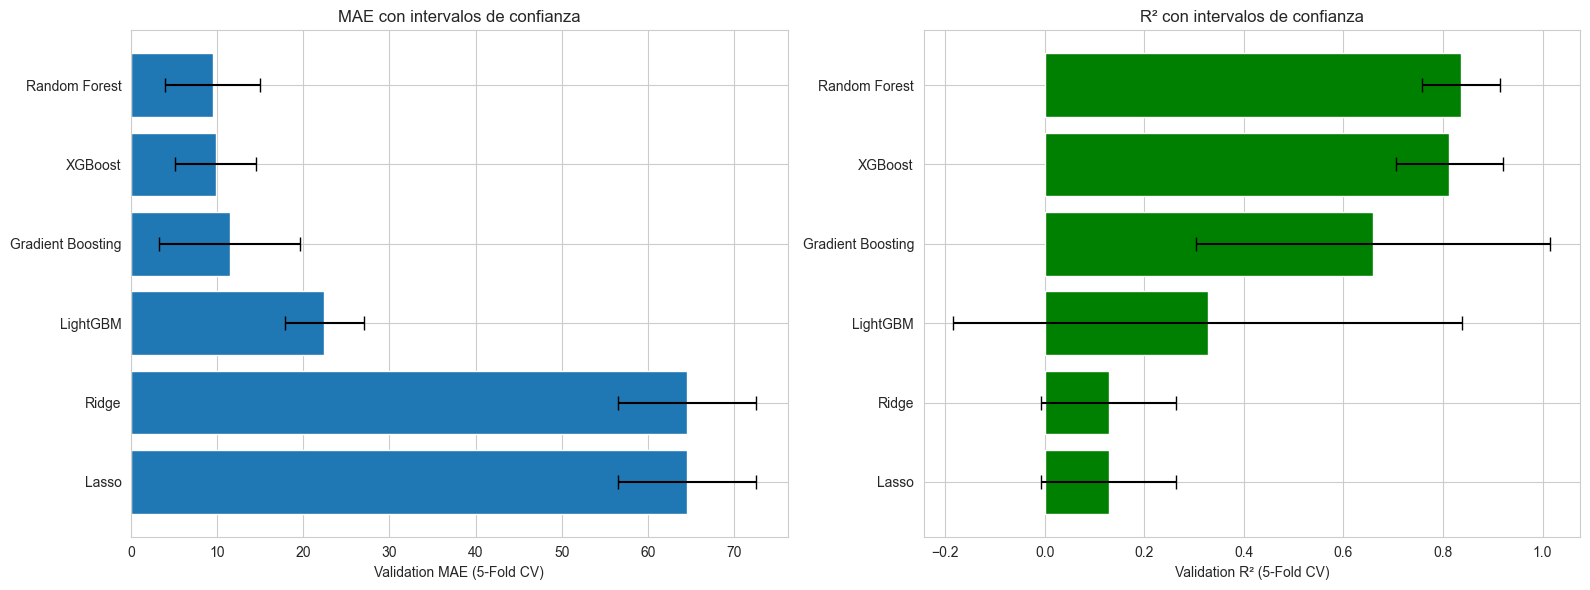

In [19]:
# Visualizar resultados de CV
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values('val_mae_mean')

print('\nRESULTADOS DE CROSS-VALIDATION (ordenados por Val MAE)')
print('=' * 70)
print(cv_df[['val_mae_mean', 'val_mae_std', 'val_r2_mean', 'val_r2_std']].to_string())

# Gráfico de comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE con barras de error
axes[0].barh(cv_df.index, cv_df['val_mae_mean'], xerr=cv_df['val_mae_std'], capsize=5)
axes[0].set_xlabel('Validation MAE (5-Fold CV)')
axes[0].set_title('MAE con intervalos de confianza')
axes[0].invert_yaxis()

# R² con barras de error
axes[1].barh(cv_df.index, cv_df['val_r2_mean'], xerr=cv_df['val_r2_std'], capsize=5, color='green')
axes[1].set_xlabel('Validation R² (5-Fold CV)')
axes[1].set_title('R² con intervalos de confianza')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 4. Hyperparameter Tuning

Realizamos tunning de hiperparámetros para los 3 mejores modelos usando **RandomizedSearchCV**.

In [20]:
# Definir espacios de búsqueda de hiperparámetros
param_distributions = {
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0.5, 1.0, 2.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10, -1],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [20, 31, 40, 50],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Modelos a tunear (los mejores según CV)
models_to_tune = {
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
}

print('HYPERPARAMETER TUNING CON RANDOMIZEDSEARCHCV')
print('=' * 70)
print('Búsqueda: 20 iteraciones por modelo con 3-fold CV')
print('Modelos a tunear: Random Forest, Gradient Boosting, XGBoost, LightGBM')
print('Esto puede tomar varios minutos...\\n')

tuned_models = {}
tuning_results = {}

for name, model in models_to_tune.items():
    print(f'\\n{name}:')
    print('-' * 70)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions[name],
        n_iter=20,
        cv=3,
        scoring=make_scorer(mean_absolute_error, greater_is_better=False),
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train, y_train)
    
    tuned_models[name] = random_search.best_estimator_
    tuning_results[name] = {
        'best_params': random_search.best_params_,
        'best_cv_score': -random_search.best_score_
    }
    
    print(f'  Mejores parámetros: {random_search.best_params_}')
    print(f'  Mejor CV MAE: {-random_search.best_score_:.6f}')

print('\\n' + '=' * 70)
print('✅ Hyperparameter tuning completado')

HYPERPARAMETER TUNING CON RANDOMIZEDSEARCHCV
Búsqueda: 20 iteraciones por modelo con 3-fold CV
Modelos a tunear: Random Forest, Gradient Boosting, XGBoost, LightGBM
Esto puede tomar varios minutos...\n
\nRandom Forest:
----------------------------------------------------------------------
  Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
  Mejor CV MAE: 8.267350
\nGradient Boosting:
----------------------------------------------------------------------
  Mejores parámetros: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
  Mejor CV MAE: 7.675277
\nXGBoost:
----------------------------------------------------------------------
  Mejores parámetros: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
  Mejor CV

## 5. Evaluación Final en Test Set

Evaluamos los modelos tuneados en el test set para obtener la performance final.

In [21]:
print('EVALUACIÓN FINAL EN TEST SET')
print('=' * 70)
print()

final_results = {}

for name, model in tuned_models.items():
    # Predecir
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcular métricas
    final_results[name] = {
        'model': model,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    
    print(f'{name}:')
    print(f"  Train MAE: {final_results[name]['train_mae']:.6f} | Test MAE: {final_results[name]['test_mae']:.6f}")
    print(f"  Train RMSE: {final_results[name]['train_rmse']:.6f} | Test RMSE: {final_results[name]['test_rmse']:.6f}")
    print(f"  Train R²: {final_results[name]['train_r2']:.6f} | Test R²: {final_results[name]['test_r2']:.6f}")
    print()

# Crear DataFrame de resultados
results_df = pd.DataFrame([{
    'Model': name,
    'Train MAE': res['train_mae'],
    'Test MAE': res['test_mae'],
    'Train RMSE': res['train_rmse'],
    'Test RMSE': res['test_rmse'],
    'Train R²': res['train_r2'],
    'Test R²': res['test_r2']
} for name, res in final_results.items()])

results_df = results_df.sort_values('Test MAE')

print('COMPARACIÓN FINAL:')
print('=' * 70)
print(results_df.to_string(index=False))

EVALUACIÓN FINAL EN TEST SET

Random Forest:
  Train MAE: 4.848796 | Test MAE: 5.202700
  Train RMSE: 225.402542 | Test RMSE: 145.163667
  Train R²: 0.928908 | Test R²: 0.971732

Gradient Boosting:
  Train MAE: 1.379827 | Test MAE: 5.764485
  Train RMSE: 25.888695 | Test RMSE: 151.939504
  Train R²: 0.999062 | Test R²: 0.969032

XGBoost:
  Train MAE: 1.032406 | Test MAE: 6.018984
  Train RMSE: 17.513324 | Test RMSE: 160.697658
  Train R²: 0.999571 | Test R²: 0.965359

LightGBM:
  Train MAE: 14.167521 | Test MAE: 15.176328
  Train RMSE: 423.843345 | Test RMSE: 270.269034
  Train R²: 0.748630 | Test R²: 0.902013

COMPARACIÓN FINAL:
            Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²
    Random Forest   4.848796  5.202700  225.402542 145.163667  0.928908 0.971732
Gradient Boosting   1.379827  5.764485   25.888695 151.939504  0.999062 0.969032
          XGBoost   1.032406  6.018984   17.513324 160.697658  0.999571 0.965359
         LightGBM  14.167521 15.176328

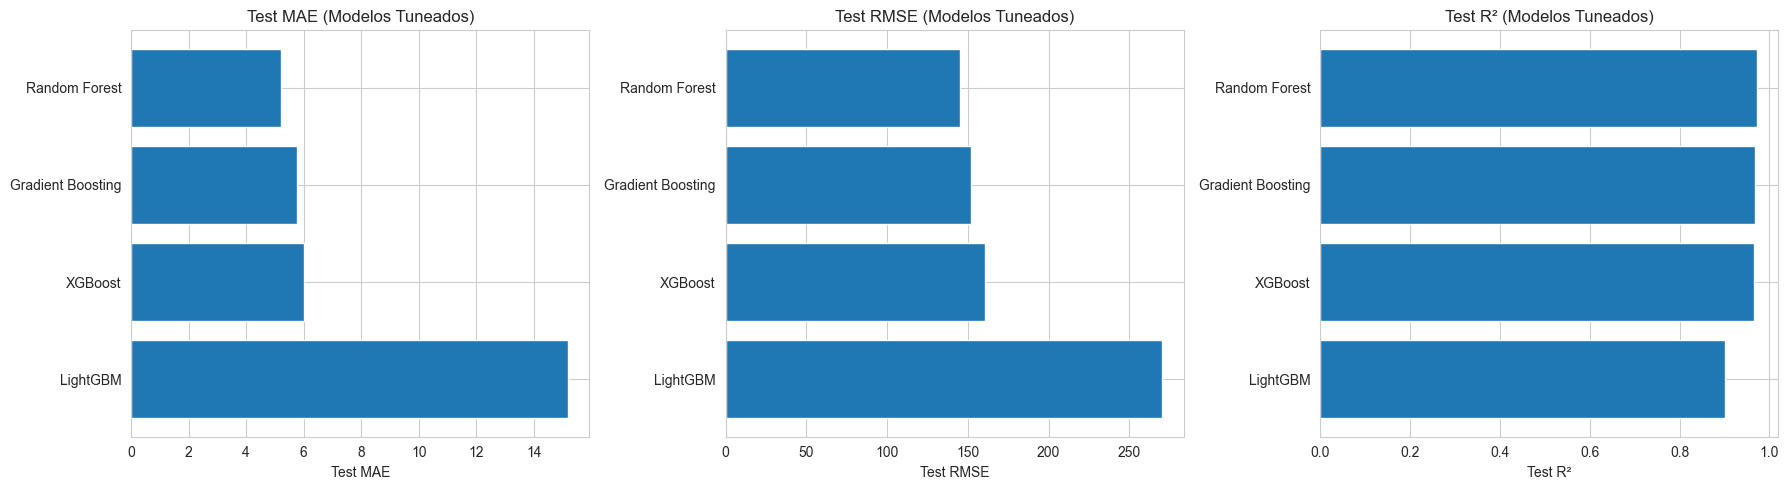

In [22]:
# Visualización de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R²']
for i, metric in enumerate(metrics):
    test_col = f'Test {metric}'
    axes[i].barh(results_df['Model'], results_df[test_col])
    axes[i].set_xlabel(test_col)
    axes[i].set_title(f'Test {metric} (Modelos Tuneados)')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

In [23]:
# Seleccionar mejor modelo
best_model_idx = results_df['Test MAE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = final_results[best_model_name]['model']

print('\nMEJOR MODELO SELECCIONADO:')
print('=' * 70)
print(f'Modelo: {best_model_name}')
print(f'Test MAE: {results_df.loc[best_model_idx, "Test MAE"]:.6f}')
print(f'Test RMSE: {results_df.loc[best_model_idx, "Test RMSE"]:.6f}')
print(f'Test R²: {results_df.loc[best_model_idx, "Test R²"]:.6f}')
print(f'\nHiperparámetros optimizados:')
print(tuning_results[best_model_name]['best_params'])


MEJOR MODELO SELECCIONADO:
Modelo: Random Forest
Test MAE: 5.202700
Test RMSE: 145.163667
Test R²: 0.971732

Hiperparámetros optimizados:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}


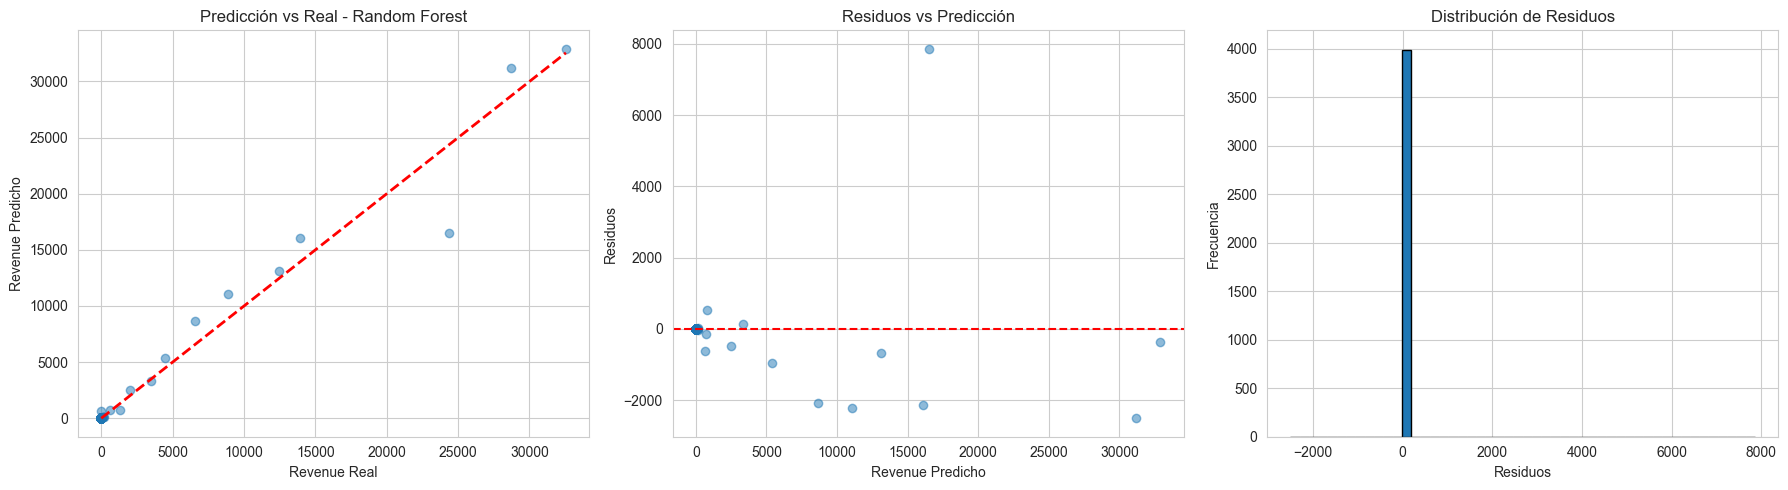

In [24]:
# Análisis de residuos del mejor modelo
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicción vs Real
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Revenue Real')
axes[0].set_ylabel('Revenue Predicho')
axes[0].set_title(f'Predicción vs Real - {best_model_name}')

# Residuos
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Revenue Predicho')
axes[1].set_ylabel('Residuos')
axes[1].set_title('Residuos vs Predicción')

# Distribución de residuos
axes[2].hist(residuals, bins=50, edgecolor='black')
axes[2].set_xlabel('Residuos')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución de Residuos')

plt.tight_layout()
plt.show()

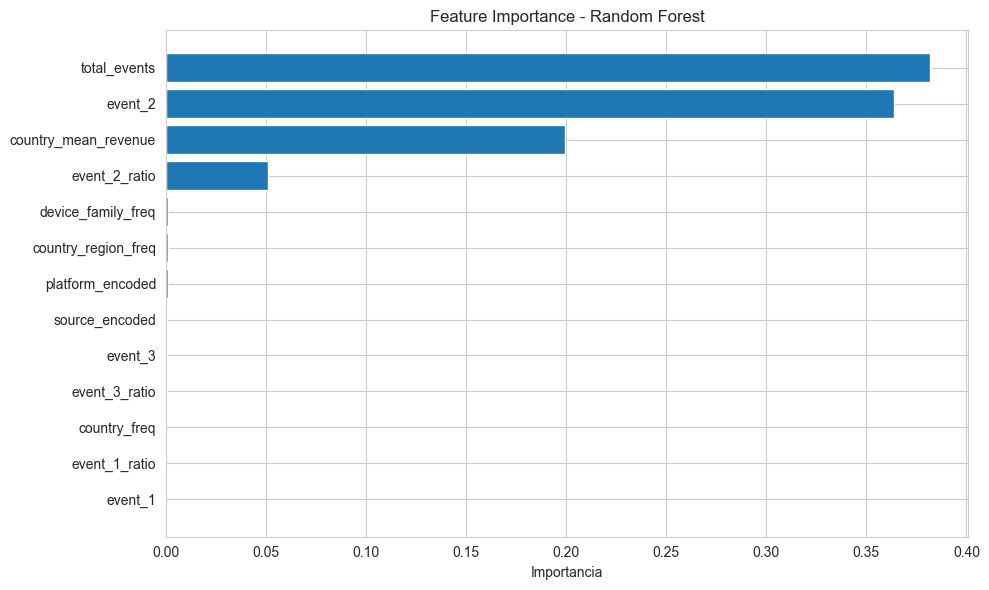


Top Features más importantes (Random Forest):
             feature  importance
        total_events    0.381899
             event_2    0.363851
country_mean_revenue    0.199306
       event_2_ratio    0.050779
  device_family_freq    0.001260
 country_region_freq    0.000852
    platform_encoded    0.000793
      source_encoded    0.000583
             event_3    0.000394
       event_3_ratio    0.000283


In [25]:
# Feature importance del mejor modelo
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f'\nTop Features más importantes ({best_model_name}):')
    print(feature_importance.head(10).to_string(index=False))

# 6. Exportación del Modelo

Guardamos el mejor modelo tuneado y sus artefactos.

In [ ]:
import os

# Directorio de artefactos
model_dir = '../src/models/artifacts_cv'
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
joblib.dump(best_model, f'{model_dir}/model.pkl')

# Guardar encoders
joblib.dump(le_source, f'{model_dir}/le_source.pkl')
joblib.dump(le_platform, f'{model_dir}/le_platform.pkl')

# Guardar metadata
metadata = {
    'feature_cols': feature_cols,
    'model_name': best_model_name,
    'test_mae': float(results_df.loc[best_model_idx, 'Test MAE']),
    'test_rmse': float(results_df.loc[best_model_idx, 'Test RMSE']),
    'test_r2': float(results_df.loc[best_model_idx, 'Test R²']),
    'best_params': tuning_results[best_model_name]['best_params'],
    'cv_score': tuning_results[best_model_name]['best_cv_score'],
    'country_mean_revenue': country_mean_revenue.to_dict(),
    'country_value_counts': df_processed['country'].value_counts().to_dict(),
    'device_family_value_counts': df_processed['device_family'].value_counts().to_dict(),
    'country_region_value_counts': df_processed['country_region'].value_counts().to_dict(),
    'training_method': 'RandomizedSearchCV with 5-fold CV'
}

joblib.dump(metadata, f'{model_dir}/metadata.pkl')

# Guardar resultados de comparación
results_df.to_csv(f'{model_dir}/model_comparison_cv.csv', index=False)

# Guardar resultados de CV
cv_df.to_csv(f'{model_dir}/cv_results.csv')

print('MODELO Y ARTEFACTOS GUARDADOS')
print('=' * 70)
print(f'Directorio: {model_dir}')
print('\nArchivos creados:')
print('  - model.pkl (modelo tuneado)')
print('  - metadata.pkl (metadata con hiperparámetros)')
print('  - le_source.pkl (label encoder)')
print('  - le_platform.pkl (label encoder)')
print('  - model_comparison_cv.csv (comparación final)')
print('  - cv_results.csv (resultados de cross-validation)')
print('\n✅ Exportación completada')

## Resumen

### Mejoras implementadas:

1. **Cross-Validation (5-fold)**: Evaluación más robusta con intervalos de confianza
2. **Hyperparameter Tuning**: RandomizedSearchCV con 20 iteraciones por modelo
3. **Comparación rigurosa**: Métricas con desviación estándar
4. **Mejor generalización**: Modelos optimizados para reducir overfitting

### Diferencias con model_development.ipynb:

| Aspecto | model_development.ipynb | model_training_with_cv.ipynb |
|---------|------------------------|-----------------------------|
| Validación | Train/Test split simple | 5-fold Cross-Validation |
| Hiperparámetros | Por defecto | Optimizados con RandomizedSearchCV |
| Métricas | Valores puntuales | Con intervalos de confianza |
| Tiempo de ejecución | ~1-2 min | ~10-15 min |
| Robustez | Básica | Alta |